# Подготовка датасета для Spaceship Titanic

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_bars(df, lst_features, lst_split = ['Transported'], ylim=(0,1)):
    """ Вывод значений для прихнаков из списка lst_features. Вычисление для них доли признкака lst_split """
    cols, i = len(lst_features)*len(lst_split), 1
    plt.figure(figsize=(cols*5, 4), facecolor ='w')     
    for f in lst_features: 
        for split in lst_split:         
            x = np.array( list(dict(df[f].value_counts()).items() ))            
            ax1 = plt.subplot(1, cols, i)
            plt.ylim(0, len(df)); plt.title(f); plt.yticks([]); # plt.xticks(x[:,0])
            plt.bar(x[:,0], x[:,1].astype(int))
            
            s = [  df.loc[df[f] == k, split].mean() for k, _ in x ]
            ax2 = ax1.twinx(); ax2.set_ylim(ylim)
            plt.plot(x[:,0], s, ":og", markersize=8)
            plt.axhline(y = (ylim[0]+ylim[1])/2, color = 'gray', linestyle = '-')
            plt.yticks(np.linspace(ylim[0],ylim[1],11)); plt.legend([split])
            plt.grid()
            i += 1
    plt.show()    
    
def plot_counts(df, lst_features, lst_split = ['Transported']):
    """ Аналогично plot_bars средствами seaborn """
    cols, i = len(lst_features)*len(lst_split), 1
    plt.figure(figsize=(cols*5, 4), facecolor ='w')     
    for f in lst_features: 
        for split in lst_split:         
            plt.subplot(1, cols, i)
            sns.countplot(x=f, hue=split, data=df).set(title=f)
            i += 1
    plt.show()    
    
#-------------------------------------------------------------------------------------------
        
def plot_float(df, lst_features, ymax):
    """ Вывод гистограмм веществественных признаков из списка lst_features """
    plt.figure(figsize=(20,8), facecolor ='w')       
    cnt = 1
    for col in lst_features: 
        if df[col].dtype == np.float64:                        
            x = df[col]
            plt.subplot(2, 6, cnt); 
            plt.hist(x, bins=30); plt.ylim(0, ymax)            
            plt.title(f"{col} [{x.min():.0f}, {x.max():.0f}]")
            cnt += 1
    plt.show()

## Пропуски данных

In [29]:
df_trn = pd.read_csv("dataset/train.csv")
df_tst = pd.read_csv("dataset/test.csv")   

print(f"df_trn: {df_trn.shape}\ndf_tst: {df_tst.shape}")

display( df_trn.isna().sum() )

print(f"Duplicate trn rows: {df_trn.duplicated().sum()}")
print(f"Duplicate tst rows: {df_tst.duplicated().sum()}")

df_trn: (8693, 14)
df_tst: (4277, 13)


PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

Duplicate trn rows: 0
Duplicate tst rows: 0


✅ Во всех колонках, кроме `PassengerId`, `Transported` есть пропуски примерно 200 на колонку (в tst по 100).<br>
✅ Дубликатов данных (строк) нет.<br>
✅ Тестовые данные половина от тренировочных

✍ Пока игнорируем все строки с пропусками и проанализировав данные, решим как заполнять пропуски

In [30]:
def remove_gaps(df):
    """ Удаляет строки содержащие хотя бы один пропуск """
    cnt = sum( len(df[df[col].isna()])   for col in df.columns )
    gaps = df.isna().any('columns')
    print(f"Share of gaps: {len(df[gaps]):4d}  ({100*gaps.mean():.1f}%); independently by columns {cnt}")
    
    df = df[~df.isna().any('columns')] 
    return df.reset_index()   
    
df_trn = remove_gaps(df_trn)
df_tst = remove_gaps(df_tst)
df_all = pd.concat([df_trn, df_tst], axis=0)          # объединённые данные (часть Transported==NaN)

Share of gaps: 2087  (24.0%); independently by columns 2324
Share of gaps:  996  (23.3%); independently by columns 1117


✅ В среднем 24% строк и в trn, и в tst имеют пропуски<br>
✅ Большинство строк имеет по одному пропуску, но есть по по два (см. последнее число)

In [31]:
df_trn.head()

,index,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## Базовые фичи

✅ Разобьём `PassengerId`, `Cabin`, `Name` на части<br>
✅ Введём суммарные траты `Tot` и признак их отсутствия `Tot0`

In [32]:
def features(df):
        
    df['Pass_GR'] = df.PassengerId.map(lambda x: x.split('_')[0])  # GR_ID
    df['Pass_ID'] = df.PassengerId.map(lambda x: x.split('_')[-1])
    
    groups = df.Pass_GR.value_counts()                            # список номеров групп с числом людей в них
    df['Size_GR'] = df.Pass_GR.map(lambda x: groups[x])           # для каждого человека резмер его группы
    df['Single']  = df.Size_GR == 1                               # одинокий путешественник
    
    df['Deck']    = df.Cabin.map(lambda x: x.split('/')[0])       # буква палубы
    df['Number']  = df.Cabin.map(lambda x: x.split('/')[1]).astype(int) # номер на палубе
    df['Side']    = df.Cabin.map(lambda x: x.split('/')[2])       # S,P - сторона номера (>)

    df['Deck_BCD']   = df.Deck.map(lambda x: x in 'BCD' )         # группировка по палубам (пригодится)
    df['Deck_BCDFA'] = df.Deck.map(lambda x: x in 'BCDFA' )        
    df['Deck_DET']   = df.Deck.map(lambda x: x in 'DET' )    

    df['Name1']   = df.Name.map(lambda x: x.split(' ')[0])        # разбиваем полное имя имя
    df['Name2']   = df.Name.map(lambda x: x.split(' ')[1])
    
    df['Tot']     = df.RoomService + df.FoodCourt + df.ShoppingMall + df.Spa + df.VRDeck   
    df['Tot0']    = df.Tot <= 0           
    
    df['Age_0']     = df.Age <= 0                                 # группы по возрастту (см. ниже)
    df['Age_1_4']   = df.Age <= 0
    df['Age_1_4']   = (df.Age >=  1) & (df.Age <=  4)
    df['Age_5_12']  = (df.Age >=  5) & (df.Age <= 12)
    df['Age_18_40'] = (df.Age >= 18) & (df.Age <= 40)    
        
    df.CryoSleep = df.CryoSleep.astype(bool)                      # из-за пропусков были object
    df.VIP       = df.VIP.astype(bool)
    df.Side      = df.Side == 'S'                                 # {S,P}
    
    
features(df_trn)
features(df_tst)

display(df_trn.head(2))
display(df_trn.describe(include=[bool]))
display(df_trn.describe(include=[object]))
display(df_trn.describe())
# df_trn.nunique()

,index,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,...,Deck_BCDFA,Deck_DET,Name1,Name2,Tot,Tot0,Age_0,Age_1_4,Age_5_12,Age_18_40
0,0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,...,True,False,Maham,Ofracculy,0.0,True,False,False,False,True
1,1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,...,True,False,Juanna,Vines,736.0,False,False,False,False,True


,CryoSleep,VIP,Transported,Single,Side,Deck_BCD,Deck_BCDFA,Deck_DET,Tot0,Age_0,Age_1_4,Age_5_12,Age_18_40
count,6606,6606,6606,6606,6606,6606,6606,6606,6606,6606,6606,6606,6606
unique,2,2,2,2,2,2,2,2,2,2,2,2,2
top,False,False,True,True,True,False,True,False,False,False,False,False,True
freq,4274,6444,3327,4021,3345,5017,3948,5547,3870,6466,6378,6346,4062


,PassengerId,HomePlanet,Cabin,Destination,Name,Pass_GR,Pass_ID,Deck,Name1,Name2
count,6606,6606,6606,6606,6606,6606,6606,6606,6606,6606
unique,6606,3,5305,3,6590,5015,8,8,2531,2112
top,0001_01,Earth,G/1476/S,TRAPPIST-1e,Gwendy Sykess,4256,01,F,Kaye,Casonston
freq,1,3566,7,4576,2,8,4734,2152,10,17


,index,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Size_GR,Number,Tot
count,6606.000000,6606.000000,6606.000000,6606.000000,6606.000000,6606.000000,6606.000000,6606.000000,6606.000000,6606.000000
mean,4372.817741,28.894036,222.991674,478.958523,178.356494,313.161520,303.780048,1.783227,599.177414,1497.248259
std,2508.595067,14.533429,644.987936,1678.592291,576.328407,1144.016291,1127.142166,1.284366,513.450585,2860.618493
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,2212.250000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,166.000000,0.000000
50%,4366.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,424.000000,739.000000
75%,6548.750000,38.000000,49.000000,82.750000,30.000000,65.000000,52.000000,2.000000,994.000000,1513.750000
max,8692.000000,79.000000,9920.000000,29813.000000,12253.000000,22408.000000,20336.000000,8.000000,1894.000000,35987.000000


## Логические признаки

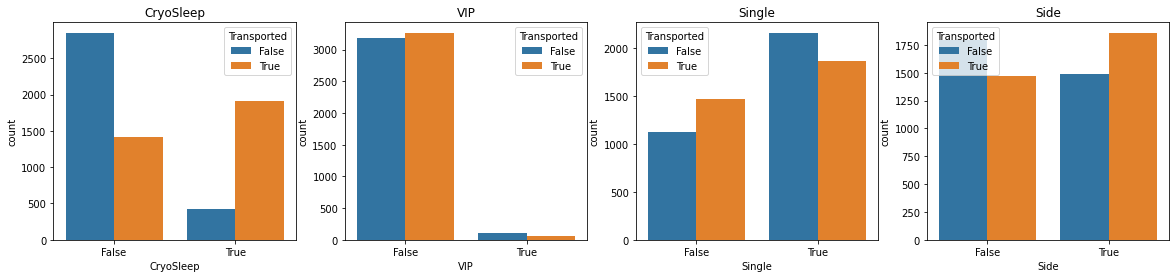

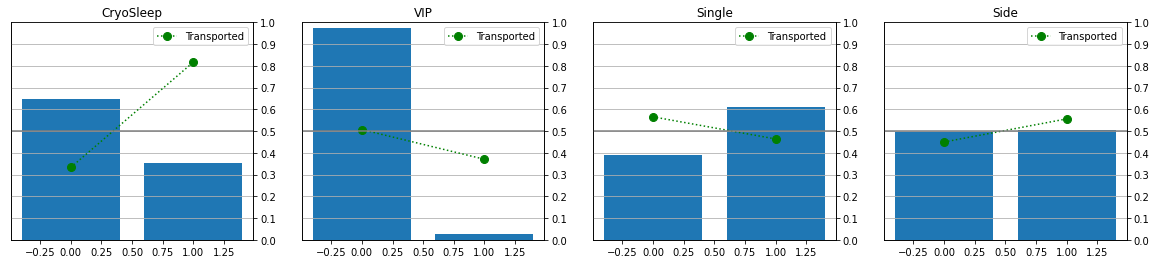

In [34]:
plot_counts(df_trn, ['CryoSleep', 'VIP', 'Single', 'Side'])
plot_bars  (df_trn, ['CryoSleep', 'VIP', 'Single', 'Side'])

## CryoSleep	

✅ `CryoSleep` и `Tot0`- важные классификационные параметры `CryoSleep`=0.82/0.33<br>
✅ Все кто был в гибернации денег не платили; 9% не спящих тоже не платили<br>
✅  Любым методом acc = **0.72** только с `CryoSleep`<br>
✅  Капсулы `CryoSleep` стоят в каютах. Видимо, корабль пересёк анамалию и больше досталось конкретным палубам, номерам и возможно общественным местам.<br>


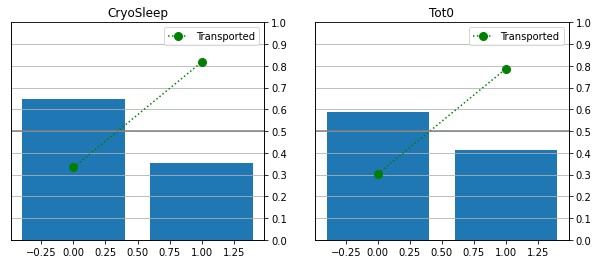

,count,Transported
CryoSleep,,
False,4274,0.332709
True,2332,0.816895


In [41]:
plot_bars  (df_trn, ['CryoSleep', 'Tot0'])
pd.DataFrame({'count':        df_trn.groupby('CryoSleep')['Transported'].count(),
              'Transported':  df_trn.groupby('CryoSleep')['Transported'].mean() })


✅ Если человек не платил, то с достоверностю 0.85 был в гебернации (для восстановления пропусков)<br>


In [45]:
display( pd.DataFrame({'count': df_trn.groupby('CryoSleep')['Tot0'].count(),
                       'Tot0':  df_trn.groupby('CryoSleep')['Tot0'].mean()}) )

display( pd.DataFrame({'count': df_trn.groupby('Tot0')['CryoSleep'].count(),
                       'Cryo':  df_trn.groupby('Tot0')['CryoSleep'].mean()}) )

,count,Tot0
CryoSleep,,
False,4274,0.094525
True,2332,1.000000


,count,Cryo
Tot0,,
False,3870,0.000000
True,2736,0.852339


In [46]:
pd.DataFrame({'count':      df_trn.groupby('Age_0')['CryoSleep'].count(),
              'CryoSleep':  df_trn.groupby('Age_0')['CryoSleep'].mean()})

,count,CryoSleep
Age_0,,
False,6466,0.351376
True,140,0.428571


✅ При df.CryoSleep=df.Tot0 (if isna) в тренировочных данных 60% CryoSleep=F будут восстановлены верно. Остальные 40% с вероятностью 0.85.

In [47]:
df = pd.read_csv("dataset/train.csv")

df = df.loc[df.CryoSleep.isna()]
df['Tot']     = df.RoomService + df.FoodCourt + df.ShoppingMall + df.Spa + df.VRDeck   
df['Tot0']    = df.Tot <= 0   
print(1-df.Tot0.mean())

0.599078341013825


## Planets

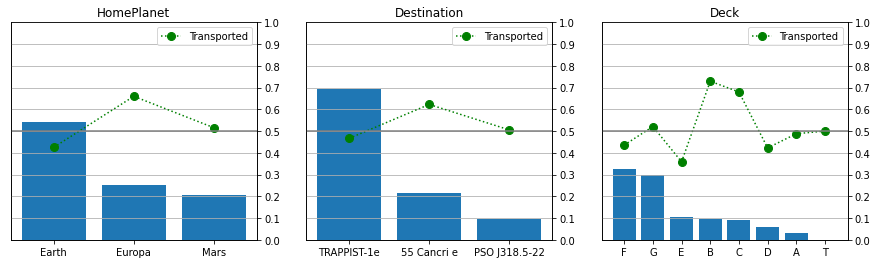

In [48]:
plot_bars(df_trn, ['HomePlanet','Destination', 'Deck'])

✅ Вероятность пропасть у `Europa`  выше, чем у `Earth`. Аналогично пропадают летящие на `55 Cancri e`<br>
✅ Европейцев селили на палубы `B, C` с которых пропасть вероятность была существенно выше. <br>
✅ Землян селили на "безопасные" палубы `G, F`.<br>

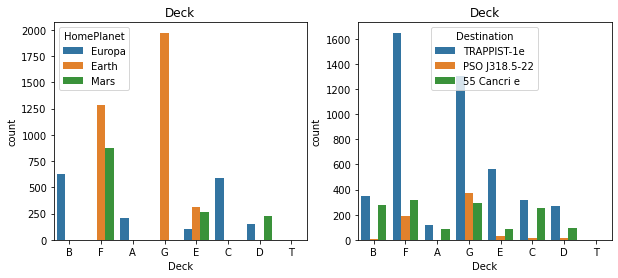

In [49]:
plot_counts(df_trn, ['Deck'], ['HomePlanet', 'Destination'])

✅ Большинство землян и марсиан летят на TRAPPIST-1e. На PSO летят в основном земляне.<br>

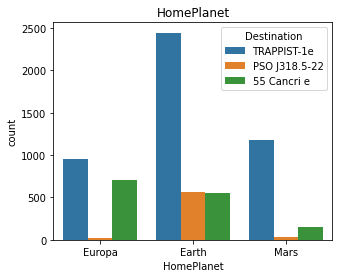

In [50]:
plot_counts(df_trn, ['HomePlanet'], ['Destination'])

✅ Обычно группа летит с одного места, но иногда на различные.<br>
✅ Жуткая история с Brighttt	 Philda	и Lyde - дети в разных кабинах на разные планеты.

In [ ]:
df_trn.loc[df_trn.Size_GR > 1,  ['PassengerId','Size_GR','Cabin','CryoSleep', 'HomePlanet','Destination', 'Name2', 'Name1', 'Age', 'Transported']].head(50)
#df_trn[ ['PassengerId','Cabin','CryoSleep', 'HomePlanet','Destination', 'Name2', 'Name1', 'Age', 'Transported']].head(20)

## Age

In [ ]:
plt.figure(figsize=(16,4))
sns.histplot(data=df_trn, x='Age', hue='Transported', binwidth=1, kde=True); plt.show()

for a in range(40):
    age = df_trn.loc[df_trn.Age == a, 'Transported']
    print(f"({a}: {len(age)} {age.mean():.3f})", end=" ")

✅ Age: 0    - очень вероятно пропасть (0.829)<br>
✅ Age: 1-4  - (0.75)<br>
✅ Age: 5-12 - (0.65)<br>
✅ Age: 18-40 - (< 0.5)<br>
✅ Младенцев и молодёжь селили на палубе `G`<br>

In [ ]:
plot_bars(df_trn, ['Deck'], ['Age'], ylim=(0,50))
plot_bars(df_trn, ['Deck'], ['Age_0'])

## Группы
✅ Слабенький, но признак пропажи - одиночная 

In [ ]:
plot_bars(df_trn, ['Single'])

## Имена

In [ ]:
df_trn['FN_END'] = df_trn.Name1.map(lambda x: x[-1])

res = dict(df_trn.FN_END.value_counts())
tot, st = 0, ""
for i, k in enumerate(res):
    x = df_trn.loc[(df_trn.FN_END == k) , 'Transported']  
    count, mean = x.count(), x.mean()
    if mean > 0.60 and count > 10:
        print(f"{k:12s}:{res[k]:3d} > count:{count:4d}, mean:{mean:.3f}")                
        st += k
        tot += count
        
print(tot, st)  

In [ ]:
df_trn['FN_SFX'] = df_trn.Name1.map(lambda x: x[-3:])

res = dict(df_trn.FN_SFX.value_counts())
tot, st = 0, []
for i, k in enumerate(res):
    x = df_trn.loc[(df_trn.FN_SFX == k) , 'Transported']  
    count, mean = x.count(), x.mean()
    if mean > 0.65 and count > 10:
        print(f"{k:12s}:{res[k]:3d} > count:{count:4d}, mean:{mean:.3f}")                
        st += [k]
        tot += count
        
print(tot, st)  

## Траты

✅  Сильная дисперсия в финансах (от 0 до 30k)<br>

In [ ]:
plot_float(df_trn, ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], ymax=300)

## Cabins

✅  6561 кают `Cabin` на 8693 человек (**1.3** человека на каюту)<br>

In [ ]:
plot_bars(df_trn, ['Deck', 'Side'])

In [ ]:
plot_bars(['Deck', 'Side', 'Size_GR'])

x = df_trn.loc[(df_trn.Tot0), 'Transported']
print(f"Tot0                     > count:{x.count():4d},   mean:{x.mean():.3f}")

x = df_trn.loc[(df_trn.CryoSleep), 'Transported']
print(f"CryoSleep==T             > count:{x.count():4d},   mean:{x.mean():.3f}")

x = df_trn.loc[(df_trn.CryoSleep == False), 'Transported']
print(f"CryoSleep==F             > count:{x.count():4d},   mean:{x.mean():.3f}")

x = df_trn.loc[(df_trn.CryoSleep) & (df_trn.Deck_BCD), 'Transported']
print(f"\nCryoSleep==T, Deck_BCD   > count:{x.count():4d},   mean:{x.mean():.3f}")

x = df_trn.loc[(df_trn.CryoSleep) & (df_trn.Deck_BCDFA), 'Transported']
print(f"CryoSleep==T, Deck_BCDFA > count:{x.count():4d},   mean:{x.mean():.3f}")

x = df_trn.loc[(df_trn.CryoSleep  == False) & (df_trn.Deck_DET), 'Transported']
print(f"CryoSleep==F, Deck_DET   > count:{x.count():4d},   mean:{x.mean():.3f}\n")

for d in 'BCDFAGET':
    number = df_trn.loc[df_trn.Deck == d].Number.astype(int)
    x = df_trn.loc[(df_trn.CryoSleep ) & (df_trn.Deck == d) , 'Transported']  
    print(f"CryoSleep==T, Deck_{d}     > count:{x.count():4d},   mean:{x.mean():.3f},    {number.max():6.0f}")    
    
for d in 'BCDFAGET':    
    x = df_trn.loc[(df_trn.Tot0 == True) & (df_trn.Deck == d), 'CryoSleep']
    print(f"Tot0==T                  > count:{x.count():4d},   Cryo:{x.mean():.3f}")    

In [ ]:
df = pd.read_csv("dataset/train.csv")
df = df.loc[df.Cabin.isna()]
df['Tot']     = df.RoomService + df.FoodCourt + df.ShoppingMall + df.Spa + df.VRDeck   
df['Tot0']    = df.Tot <= 0   
df

In [ ]:
plt.figure(figsize=(16,4))
sns.histplot(data=df_trn, x='Number', hue='Transported', binwidth=10, kde=True)


✅  Выглядит, как зависимость пропаж от номера. Но на самомо деле её нет (кроме палубы G [760-1160] и F?):

In [ ]:
for d in 'GBCDFAE':
    plt.figure(figsize=(16,3))
    sns.histplot(data=df_trn[df_trn.Deck==d], x='Number', hue='Transported', binwidth=20, kde=True)
    plt.title("Deck_"+d)
    plt.show()
   

## Test and Train 

✅ Кабины и группы пассажиров в trn и tst не пересекаются, т.е. выборка tst не вполне случайна <br>

In [ ]:
cabin_trn = set(dict(df_trn.Cabin.value_counts()).keys() )
cabin_tst = set(dict(df_tst.Cabin.value_counts()).keys() )
cabin_trn.intersection(cabin_tst)

In [ ]:
gr_trn = set(dict(df_trn.Pass_GR.value_counts()).keys() )
gr_tst = set(dict(df_tst.Pass_GR.value_counts()).keys() )
gr_trn.intersection(gr_tst)

In [ ]:
deck_trn = set(dict(df_trn.Deck.value_counts()).keys() )
deck_tst = set(dict(df_tst.Deck.value_counts()).keys() )
deck_trn.intersection(deck_tst)

In [ ]:
# Средние значения bool признаков для тестовых и тренировочных данных:
for col in df_tst:                          
    if df_tst[col].dtype == bool:        
        m_tst, m_trn =   df_tst[col].mean(), df_trn[col].mean(),
        print(f"{m_tst:.2f}   {m_trn:.2f}  {m_tst-m_trn:5.2f}  {col}")

# Conclusion

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

def add_features1(df):
    """ Разбиваем id-пасажира на номер группы и положение в группе, добавляем численность группы """
    
    df['Pass_GR'] = df.PassengerId.map(lambda x: x.split('_')[0])  # GR_ID
    df['Pass_ID'] = df.PassengerId.map(lambda x: x.split('_')[1])

    groups = df.Pass_GR.value_counts()                            # число людей в данной группе    
    df['Size_GR'] = df['Pass_GR'].map(lambda x: groups[x])     # для каждого человека резмер его группы
    
    df['Single']  = df.Size_GR == 1
    df.Size_GR    = df.Size_GR.astype(float)
    
    return df

#-------------------------------------------------------------------------------------    

def fill_gaps_in_float(df):
    """ Заполняем пропуски в вещественных данных: Age, Spents """
    
    for col in df:                        
        if df[col].dtype == float:  
            if col == "Age":
                df.loc[df[col].isnull(), col] = df[col].median()  # самый типичный возраст
            else:
                df.loc[df[col].isnull(), col] = 0                 # не знаем - не тратил :)
                
    df['Tot']   = df.RoomService + df.FoodCourt + df.ShoppingMall + df.Spa + df.VRDeck   
    df['Tot0']  = df.Tot <= 0   
    return df

#-------------------------------------------------------------------------------------    

def fill_gaps_in_CryoSleep_VIP(df):
    """ Заполняем пропуски в CryoSleep, VIP """
    
    gaps = df.CryoSleep.isnull()                                   # все записи с неизвестной гибернацией
    df.loc[gaps, 'CryoSleep'] = df.loc[gaps, 'Tot0']               # не тратил - видимо спал
    df.CryoSleep = df.CryoSleep.astype(bool)
        
    gaps = df.VIP.isnull()
    df.loc[gaps, 'VIP'] = df.loc[gaps, 'Tot'] >= 10000             # немного надумано, но VIP-пов мало,     
    df.VIP = df.VIP.astype(bool)
    return df    
        
#-------------------------------------------------------------------------------------    

def fill_gaps_from_group(df, col):
    """ Заполняем пропуски в колонке col по значениям из данной группы"""
    indx = df[df[col].isnull()].index
    for i in indx:
        ID = df.iloc[i].Pass_GR
        for k in range(1, 6):
            if i-k >=0 and df.iloc[i-k].Pass_GR == ID:
                df.iloc[i, df.columns.get_loc(col)] = df.iloc[i-k, df.columns.get_loc(col)]
                break            
            elif i+k < len(df) and df.iloc[i+k].Pass_GR == ID:
                df.iloc[i, df.columns.get_loc(col)] = df.iloc[i+k, df.columns.get_loc(col)]
                break         
    return df

#-------------------------------------------------------------------------------------    

def fill_gaps_in_objects(df):
    """ Заменяем оставшиеся NaN на ? """
    for col in df:
        if df[col].dtype == object:  
            if col == "Cabin":
                df.loc[df[col].isnull(), col] = "?/-1/?"         
            elif col == "Name":
                df.loc[df[col].isnull(), col] = "? ?"                         
            else:
                df.loc[df[col].isnull(), col] = "?"         
            
            #df.loc[df[col].isnull(), col] = df[col].mode()[0]        # for categorical - most frequent value  - not good idea            
            #if col not in ["GAPS","Transported"]:   df[col] = df[col].astype(str)                  
    return df                

#-------------------------------------------------------------------------------------        

def amounts_mean(df, lst = ["Tot", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]):   
    """
    Одна группа могла записывать траты деньги на одного члена (например, главу), но ходить все, кто не в капсуле
    """
    for ls in lst:
        df[ls + "_MEAN"] = 0

    ids = dict(df.Pass_ID.value_counts())
    for ID, NUM in ids.items():            
        if NUM == 1:
            break            
        for ls in lst:            
            dd = df.loc[(df.Pass_ID == ID) & (df.CryoSleep == False), ls]
            df.loc[dd.index, ls+'_MEAN'] = dd.mean()                                        
    return df    
    
#-------------------------------------------------------------------------------------        

def add_features2(df):
    """ Остальные фичи """

    for col in  ['RoomService', 'FoodCourt',  'ShoppingMall', 'Spa', 'VRDeck']:
        df[col+"1"] = df[col] > 1000                    # активно тратили (? порог)
        share = col+"_SHARE"
        df[share] = df[col] / df['Tot']                 # доля от общих трат
        df.loc[df[share].isnull(), share] = 0           # было деление на 0    
        
    df['Age_0']     = df.Age <= 0
    df['Age_1_4']   = df.Age <= 0
    df['Age_1_4']   = (df.Age >=  1) & (df.Age <=  4)
    df['Age_5_12']  = (df.Age >=  5) & (df.Age <= 12)
    df['Age_18_40'] = (df.Age >= 18) & (df.Age <= 40)        

    df['Deck']      = df.Cabin.map(lambda x: x.split('/')[0])
    df['Number']    = df.Cabin.map(lambda x: x.split('/')[1]).astype(float)
    df['Side']      = df.Cabin.map(lambda x: x.split('/')[2])    

    df['Deck_BCD']  = df.Deck.map(lambda x: x in 'BCD' )       # группировка по палубам (пригодится)
    df['Deck_BCDFA']= df.Deck.map(lambda x: x in 'BCDFA' )        
    df['Deck_DET']  = df.Deck.map(lambda x: x in 'DET' )    
    
    df['Numbers_G1'] = (df.Deck == 'G') &  ((df.Number >=760) & (df.Number <= 1160))
    df['Numbers_G2'] = (df.Deck == 'G') &  ((df.Number < 760) | (df.Number >  1160))    
    
    df['CryoSleep_Deck_BCDFA'] = (df.CryoSleep  == True)  & (df.Deck_BCDFA)     
    df['~CryoSleep_Deck_DET']  = (df.CryoSleep  == False) & (df.Deck_DET)     
    
    df['Name1']     = df.Name.map(lambda x: x.split(' ')[0])
    df['Name2']     = df.Name.map(lambda x: x.split(' ')[1])
       
    df.CryoSleep    = df.CryoSleep.astype(bool)
    df.VIP          = df.VIP.astype(bool)
    df.Side         = df.Side == 'S'                 # {S,P}
    return df

#-------------------------------------------------------------------------------------    

def normalize(df):  
    for col in  ['RoomService', 'FoodCourt',  'ShoppingMall', 'Spa', 'VRDeck']:
        df[col] /= 2000                            # ближе к 1 
    df.Tot      /= 2000        
    df.Age      /= 80
    df.Number   /= 2000
    
    return df
#-------------------------------------------------------------------------------------    

def vectorize(df):
    for col in ['Earth', 'Europa', 'Mars']:
        df[col] = df.HomePlanet == col
    for col in ['TRAPPIST-1e', '55 Cancri e', 'PSO J318.5-22']:        
        df[col] = df.Destination == col        
    for col in "BCDFAGET":
        df[col] = df.Deck == col                
        
    return df
#-------------------------------------------------------------------------------------    

def prepare_data(df):
    df = add_features1(df)
    
    df = fill_gaps_in_float(df)
    df = fill_gaps_in_CryoSleep_VIP(df)
    df = fill_gaps_from_group(df, 'Cabin')
    df = fill_gaps_from_group(df, 'HomePlanet')
    df = fill_gaps_from_group(df, 'Destination')  # не очень надёжно    
    df = fill_gaps_in_objects(df)
    
    df = add_features2(df)
    
    df = normalize(df)
    df = vectorize(df)
    
    return df        

In [ ]:
df_trn = pd.read_csv("dataset/train.csv")
df_tst = pd.read_csv("dataset/test.csv")     

df_trn = prepare_data(df_trn)
df_tst = prepare_data(df_tst)

display(df_trn.info())
display(df_tst.info())
display(df_trn.describe(include=[bool]))

print("total features:", len(df_trn.columns))
columns = list(df_trn.columns)
print([col for col in columns if df_trn[col].dtype==bool and col != 'Transported'])
print([col for col in columns if df_trn[col].dtype==float])